In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
    %tensorflow_version 2.x
except Exception as e:
    print("Error:", e)


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import tensorflow as tf


In [4]:
tf.__version__

'2.15.0'

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os  # file operations
from PIL import Image  # Python Imaging Library
from tensorflow.keras import layers
import time
from IPython import display


In [6]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


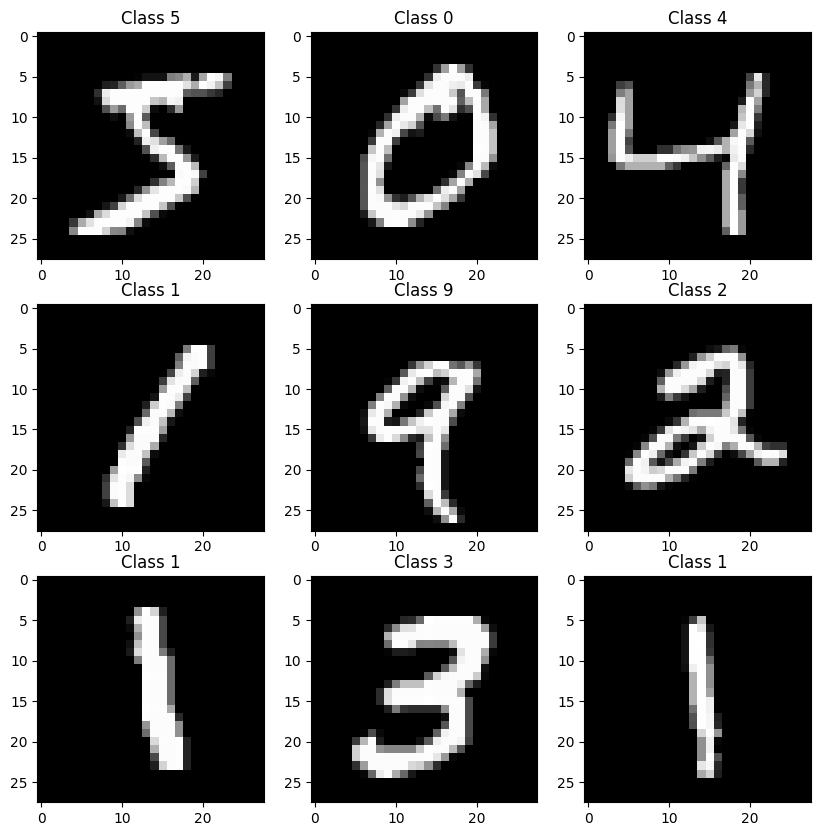

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i], cmap="gray", interpolation="none")
    plt.title("Class {}".format(train_labels[i]))
plt.show()

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to range (-1, 1)


In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices (train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape layer
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    # Conv2DTranspose layer 1
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose layer 2
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose layer 3
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

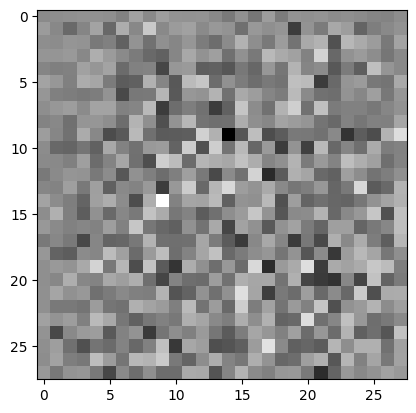

In [13]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
generator?

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    # Dropout layer
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    # Another Dropout layer
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

# Create discriminator model
discriminator = make_discriminator_model()

# Use the (as yet untrained) discriminator to classify the generated images as real or fake.
# The model will be trained to output positive values for real images, and negative values for fake images:
generated_image = tf.random.normal([1, 28, 28, 1])  # Example generated image
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.0374011]], shape=(1, 1), dtype=float32)


In [16]:
discriminator?

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
import tensorflow as tf

# Define optimizer for the generator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define optimizer for the discriminator
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Check the documentation for tf.keras.optimizers.Adam
tf.keras.optimizers.Adam?


In [19]:
checkpoint_dir = "training_checkpoints"

# Define the checkpoint prefix
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a checkpoint instance
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16

In [21]:
tf.random.normal?


In [22]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [28]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, 0] * 127.5 + 127.5), cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

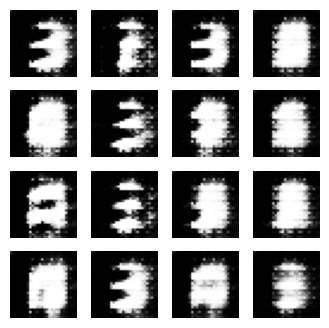

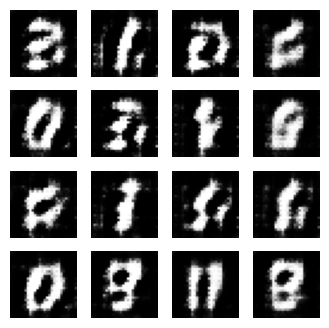

In [29]:
train(train_dataset, EPOCHS)